In [1]:
import numpy as np
import pandas as pd
import os
import random
import shutil
import cv2
from tqdm import tqdm
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

2024-02-29 07:12:47.388848: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-29 07:12:47.848877: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/foc-dba-38-0026-c/.local/lib/python3.8/site-packages/cv2/../../lib64:
2024-02-29 07:12:47.848912: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/foc-dba-38-0026-c/.local/lib/python3.8/site-pack

In [6]:
dir = "/home/foc-dba-38-0026-c/skin_detction/synthezised_dataset/train"

In [7]:
# List subdirectories and sort them in the desired order
subdirectories = [subdir for subdir in os.listdir(dir) if os.path.isdir(os.path.join(dir, subdir))]
desired_order = ['Dry', 'Normal', 'Oily']
subdirectories = sorted(subdirectories, key=lambda x: desired_order.index(x))

# Count the number of image files in each subdirectory
for subdir in subdirectories:
    sub_dir_path = os.path.join(dir, subdir)
    image_files = [file for file in os.listdir(sub_dir_path) if file.lower().endswith(('.jpg','png','jpeg'))]
    num_images = len(image_files)

    print(f"Subdirectory: {subdir}, Number of images: {num_images}")

Subdirectory: Dry, Number of images: 165
Subdirectory: Normal, Number of images: 121
Subdirectory: Oily, Number of images: 273


In [8]:
# Create a dictionary to store unique pixel heights and widths for each class
class_pixel_info = {class_name: {'heights': set(), 'widths': set()} for class_name in desired_order}

# Iterate through the classes in the desired order
for class_name in desired_order:
    class_dir = os.path.join(dir, class_name)
    image_files = [file for file in os.listdir(class_dir) if file.lower().endswith(('.jpg','png','jpeg'))]

    # Calculate unique pixel heights and widths for each image in the class
    for image_file in image_files:
        image_path = os.path.join(class_dir, image_file)
        with Image.open(image_path) as img:
            width, height = img.size
            class_pixel_info[class_name]['heights'].add(height)
            class_pixel_info[class_name]['widths'].add(width)

# Print unique pixel heights and widths for each class
for class_name, pixel_info in class_pixel_info.items():
    print(f"Class: {class_name}")
    print("Unique Pixel Heights:", pixel_info['heights'])
    print("Unique Pixel Widths:", pixel_info['widths'])
    print()


Class: Dry
Unique Pixel Heights: {480, 196, 393, 300, 728, 1080, 221}
Unique Pixel Widths: {640, 258, 330, 300, 590, 1296, 1080}

Class: Normal
Unique Pixel Heights: {640, 866, 387, 450, 612, 1000, 1960, 360, 459, 683, 1167, 1300, 692, 408, 957}
Unique Pixel Widths: {640, 1024, 866, 1600, 612, 1000, 459, 1300, 2936, 667, 318, 639}

Class: Oily
Unique Pixel Heights: {640, 1920, 259, 645, 653, 270, 1037, 3088, 400, 2576, 401, 531, 787, 280, 546, 1194, 300, 434, 1334, 183, 1080, 700, 194, 334, 1104, 720, 210, 853, 213, 351, 225, 360, 1900, 628, 244, 374, 639}
Unique Pixel Widths: {640, 1280, 259, 2180, 390, 1417, 1932, 270, 2320, 400, 275, 540, 168, 1704, 1200, 309, 1080, 194, 1100, 2381, 206, 980, 600, 602, 351, 480, 225, 736, 1000, 237, 750, 240, 379}



In [9]:
# Output Path for data
output_path = "/home/foc-dba-38-0026-c/skin_detction/synthezised_dataset"

In [10]:
# Create training and validating classes
classes = ['Dry', 'Normal', 'Oily']
validation_percentage = 0.1

# Define the directories for training and validation sets
train_dir = os.path.join(output_path, "train")
validation_dir = os.path.join(output_path, "valid")

# Create validation directories if they don't exist
for class_name in classes:
    os.makedirs(os.path.join(validation_dir, class_name), exist_ok=True)

# Move 10% of images from training set to validation set
for class_name in classes:
    images = os.listdir(os.path.join(train_dir, class_name))
    num_validation_images = int(len(images) * validation_percentage)
    validation_images = random.sample(images, num_validation_images)
    
    for image_name in validation_images:
        src_path = os.path.join(train_dir, class_name, image_name)
        dst_path = os.path.join(validation_dir, class_name, image_name)
        shutil.move(src_path, dst_path)

print("Images moved from training set to validation set.")


Images moved from training set to validation set.


In [11]:
train_dir = os.path.join(output_path, 'train')
validation_dir = os.path.join(output_path, 'valid')

# Directory with training images
# train_combination_dir = os.path.join(train_dir, 'Combination')
train_dry_dir = os.path.join(train_dir, 'Dry')
train_normal_dir = os.path.join(train_dir, 'Normal')
train_oily_dir = os.path.join(train_dir, 'Oily')


# Directory with validation cat/dog pictures
# validation_combination_dir = os.path.join(validation_dir, 'Combination')
validation_dry_dir = os.path.join(validation_dir, 'Dry')
validation_normal_dir = os.path.join(validation_dir, 'Normal')
validation_oily_dir = os.path.join(validation_dir, 'Oily')

In [12]:
def count_images_in_folder(folder_path):
    return sum(1 for file in os.listdir(folder_path) if file.endswith(('.jpg', '.png','jpeg')))

# Define your directory paths
directories = {
    'Train dry skin Images': train_dry_dir,
    'Train normal skin Images': train_normal_dir,
    'Train oily skin Images': train_oily_dir,
    '\nValidation dry skin Images': validation_dry_dir,
    'Validation normal skin Images': validation_normal_dir,
    'Validation oily skin Images': validation_oily_dir
}

# Count and print the image counts for each directory
for directory_name, directory_path in directories.items():
    image_count = count_images_in_folder(directory_path)
    print(f"{directory_name}: {image_count}")

Train dry skin Images: 149
Train normal skin Images: 109
Train oily skin Images: 246

Validation dry skin Images: 16
Validation normal skin Images: 12
Validation oily skin Images: 27


In [13]:
# Collect all unique labels from the training and validation data
classes = []
for dirpath in [train_dir, validation_dir]:
    for dirname in os.listdir(dirpath):
        if not dirname.startswith('.'):
            classes.append(dirname)
classes = np.unique(classes)

In [14]:
print(classes)

['Dry' 'Normal' 'Oily']


In [17]:
# Define the input shape and number of classes
input_shape = (248, 248, 3)
num_classes = 3

In [18]:
import tensorflow as tf

# Define a custom attention layer with mask
class AttentionLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        super(AttentionLayer, self).build(input_shape)

    def call(self, inputs, mask=None):
        # Compute attention weights
        attention_weights = tf.nn.softmax(inputs, axis=1)
        # Apply attention weights to inputs
        if mask is not None:
            attention_weights *= mask
            # Normalize attention weights
            attention_weights /= tf.reduce_sum(attention_weights, axis=1, keepdims=True)
        # Apply attention weights to inputs
        weighted_inputs = inputs * attention_weights
        # Sum along the feature map dimension to compute the attended features
        attended_features = tf.reduce_sum(weighted_inputs, axis=1)
        return attended_features

# Define your CNN architecture with attention and mask
model = tf.keras.models.Sequential([
    # Convolutional layers
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(248, 248, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    # Attention layer with mask
    AttentionLayer(),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # Dense layers
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])



In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 246, 246, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 123, 123, 32)     0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 121, 121, 64)      18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 60, 60, 64)       0         
 2D)                                                             
                                                                 
 attention_layer_1 (Attentio  (None, 60, 64)           0         
 nLayer)                                                         
                                                        

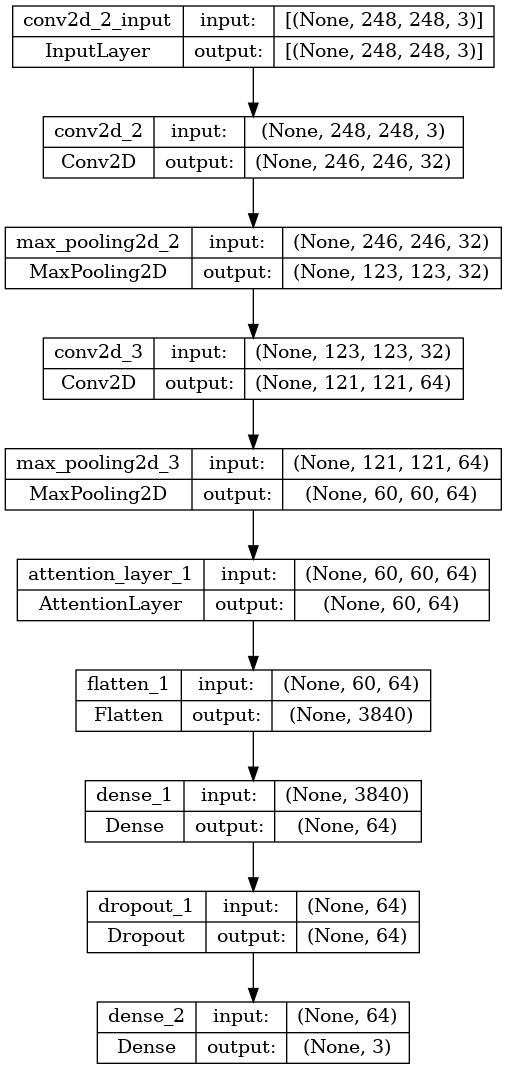

In [20]:
from tensorflow.keras.utils import plot_model

# Visualize the model architecture
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

In [21]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255.
train_datagen = ImageDataGenerator( rescale = 1.0/255. )
test_datagen  = ImageDataGenerator( rescale = 1.0/255. )

# --------------------
# Flow training images in batches of 20 using train_datagen generator
# --------------------
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=16,
                                                    class_mode='categorical',
                                                    color_mode='rgb',
                                                    target_size=(248, 248))
# --------------------
# Flow validation images in batches of 20 using test_datagen generator
# --------------------
validation_generator =  test_datagen.flow_from_directory(validation_dir,
                                                         batch_size=1,
                                                         class_mode='categorical',
                                                         color_mode='rgb',
                                                         target_size=(248, 248))

Found 504 images belonging to 3 classes.
Found 55 images belonging to 3 classes.


In [22]:
from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics = ['accuracy'])

In [23]:
history = model.fit(
            train_generator,
            epochs=25,
            validation_data=validation_generator,
            verbose=2)

Epoch 1/25


2024-02-29 07:33:19.787283: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2024-02-29 07:33:19.788013: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:234] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.6
2024-02-29 07:33:19.788023: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:237] Used ptxas at ptxas
2024-02-29 07:33:19.788076: W tensorflow/compiler/xla/stream_executor/gpu/redzone_allocator.cc:318] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2024-02-29 07:33:19.873287: W tenso

32/32 - 5s - loss: 1.0738 - accuracy: 0.4782 - val_loss: 0.9962 - val_accuracy: 0.4909 - 5s/epoch - 166ms/step
Epoch 2/25
32/32 - 3s - loss: 0.9432 - accuracy: 0.5317 - val_loss: 0.7821 - val_accuracy: 0.6909 - 3s/epoch - 85ms/step
Epoch 3/25
32/32 - 3s - loss: 0.7642 - accuracy: 0.6726 - val_loss: 0.7039 - val_accuracy: 0.8364 - 3s/epoch - 86ms/step
Epoch 4/25
32/32 - 3s - loss: 0.6696 - accuracy: 0.6825 - val_loss: 0.6085 - val_accuracy: 0.7818 - 3s/epoch - 85ms/step
Epoch 5/25
32/32 - 3s - loss: 0.5307 - accuracy: 0.7599 - val_loss: 0.5679 - val_accuracy: 0.7818 - 3s/epoch - 85ms/step
Epoch 6/25
32/32 - 3s - loss: 0.5304 - accuracy: 0.7698 - val_loss: 0.5316 - val_accuracy: 0.7818 - 3s/epoch - 86ms/step
Epoch 7/25
32/32 - 3s - loss: 0.5178 - accuracy: 0.7738 - val_loss: 0.5805 - val_accuracy: 0.8182 - 3s/epoch - 86ms/step
Epoch 8/25
32/32 - 3s - loss: 0.4832 - accuracy: 0.8036 - val_loss: 0.5451 - val_accuracy: 0.7818 - 3s/epoch - 85ms/step
Epoch 9/25
32/32 - 3s - loss: 0.4358 - acc

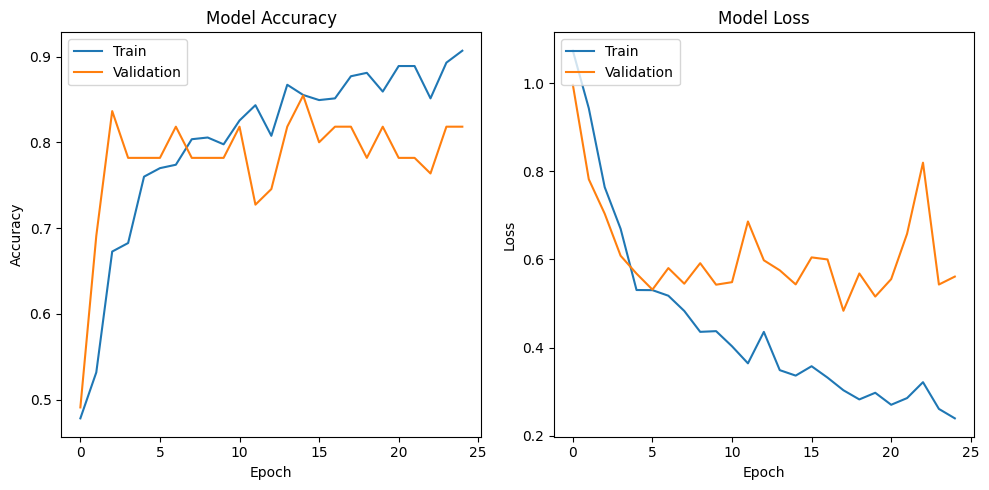

In [24]:
# Plot training & validation accuracy values
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


In [25]:
model.save("/home/foc-dba-38-0026-c/skin_detction/Version_4.2/custom_model_version4_2.h5")